# RNA-seq - QC & processing
- goal: filtered and normalized data
- input: raw counts
- output: filtered and normalized counts, gene annotations

In [1]:
# set correct working directory -> project folder
getwd()
setwd('..')
getwd()

[1] "/home/sreichl/projects/bmdm-stim/src"

[1] "/home/sreichl/projects/bmdm-stim"

In [2]:
# load libraries
library(limma)
library(ggplot2, quietly=T)
library(data.table, quietly=T)
library(pheatmap, quietly=T)
library(GGally)
library('biomaRt')
library(edgeR)
library(EDASeq)
library(cqn)
options(stringsAsFactors=F)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort

In [208]:
# util function

# adapted from EDASeq::getGeneLengthAndGCContent to work with specific ensembl (otherwise data does not match or genes are not found)
# returns exon gc content and exon lengths of transcripts for conditional quantile normalization
getGeneLengthAndGCContent <- function(id, id.type, ensembl){
    inp.id <- id
    message( paste0( "Downloading sequence",
        ifelse(length(id) > 1, "s", ""), " ..."))
    if(length(id) > 100) message("This may take a few minutes ...")

    # download sequence
    # (1) get exon coordinates
    attrs <- c(id.type, "ensembl_exon_id",
        "chromosome_name", "exon_chrom_start", "exon_chrom_end")
    coords <- getBM(filters=id.type, attributes=attrs, values=id, mart=ensembl)
    id <- unique(coords[,id.type])
    coords <- GRangesList(sapply(id,
        function(i)
        {
            i.coords <- coords[coords[,1]== i, 3:5]
            g <- GRanges(i.coords[,1], IRanges(i.coords[,2],i.coords[,3]))
            return(g)
        }), compress=FALSE)
    coords <- reduce(coords)
    len <- sum(width(coords))

    # (2) get genes and sequences
    sel <- c(id.type, "start_position", "end_position")
    gene.pos <- getBM(attributes = sel, filters=id.type, values=id,
                      mart=ensembl)
    gene.seqs <- getSequence(id=id,
        type=id.type, seqType="gene_exon_intron", mart=ensembl)

    # (3) get exonic sequences and correspondig GC content
    gc.cont <- sapply(id,
        function(i)
        {
            # exon coordinates, gene position & sequence for current id i
            ecoords <- coords[[i]]
            gpos <- gene.pos[gene.pos[,id.type] == i,
                    c("start_position", "end_position")]
            gseq <- DNAString(
                gene.seqs[gene.seqs[,id.type] == i, "gene_exon_intron"])

            # exon coordinates relative to gene position
            start <- start(ranges(ecoords)) - gpos[1,1] + 1
            end <- end(ranges(ecoords)) - gpos[1,1] + 1
            eseq <- gseq[IRanges(start, end)]
            gc.cont <- sum(alphabetFrequency(eseq, as.prob=TRUE)[c("C","G")])
            return(gc.cont)
        }
    )

    res <- cbind(len, gc.cont)
    colnames(res) <- c("length", "gc")
    rownames(res) <- id

    # (4) order according to input ids
    not.found <- !(inp.id %in% rownames(res))
    na.col <- rep(NA, sum(not.found))
    rn <- c(rownames(res), inp.id[not.found])
    res <- rbind(res, cbind(na.col, na.col))
    rownames(res) <- rn
    res <- res[inp.id,]
    return(res)
}

In [5]:
# configs
data_path <- file.path('results','RNA','counts')
metadata_path <- file.path('metadata','RNA_sample_metadata.csv')
results_path <- file.path('results','RNA','qc')

In [6]:
# make directories if not exist
dir.create(results_path, showWarnings = FALSE)

# Load data

In [7]:
# load annotations
annot <- read.csv(file=metadata_path, row.names=1)
dim(annot)
head(annot)

[1] 66 10

library   timepoint.after.thawing cell_line
RNA_PT76_R1_C_albicans_2h  Quant-seq d010                    BMDM     
RNA_PT82_R1_C_albicans_24h Quant-seq d010                    BMDM     
RNA_PT76_R1_C_albicans_4h  Quant-seq d010                    BMDM     
RNA_PT76_R1_C_albicans_6h  Quant-seq d010                    BMDM     
RNA_PT82_R1_C_albicans_8h  Quant-seq d010                    BMDM     
RNA_PT76_R1_untreated_0h   Quant-seq d010                    BMDM     
                           Treatment  Treatment_time mouse_pool sex    organism
RNA_PT76_R1_C_albicans_2h  C_albicans 2h             PT62_c     female mouse   
RNA_PT82_R1_C_albicans_24h C_albicans 24h            PT62_c     female mouse   
RNA_PT76_R1_C_albicans_4h  C_albicans 4h             PT62_c     female mouse   
RNA_PT76_R1_C_albicans_6h  C_albicans 6h             PT62_c     female mouse   
RNA_PT82_R1_C_albicans_8h  C_albicans 8h             PT62_c     female mouse   
RNA_PT76_R1_untreated_0h   untreated  0h             PT62_c     female mouse   
                           bio.replicate experiment_id
RNA_PT76_R1_C_albicans_2h  R1            PT76         
RNA_PT82_R1_C_albicans_24h R1            PT82         
RNA_PT76_R1_C_albicans_4h  R1            PT76         
RNA_PT76_R1_C_albicans_6h  R1            PT76         
RNA_PT82_R1_C_albicans_8h  R1            PT82         
RNA_PT76_R1_untreated_0h   R1            PT76

In [8]:
# rename columns
names(annot)[names(annot) == 'Treatment'] <- 'treatment'
names(annot)[names(annot) == 'Treatment_time'] <- 'time'
names(annot)[names(annot) == 'experiment_id'] <- 'experiment'
annot$sample_name <- rownames(annot)

In [9]:
# load data -> without symbols, because symbols have duplicates
data <- read.csv(file=file.path(data_path,'all.tsv'), row.names=1, sep='\t')
dim(data)
head(data)

[1] 55487    66

RNA_PT76_R1_C_albicans_2h RNA_PT76_R1_C_albicans_4h
ENSMUSG00000102693 0                         0                        
ENSMUSG00000064842 0                         0                        
ENSMUSG00000051951 0                         0                        
ENSMUSG00000102851 0                         0                        
ENSMUSG00000103377 0                         0                        
ENSMUSG00000104017 0                         0                        
                   RNA_PT76_R1_C_albicans_6h RNA_PT76_R1_IFN_beta_2h
ENSMUSG00000102693 0                         0                      
ENSMUSG00000064842 0                         0                      
ENSMUSG00000051951 0                         0                      
ENSMUSG00000102851 0                         0                      
ENSMUSG00000103377 0                         0                      
ENSMUSG00000104017 0                         0                      
                   RNA_PT76_R1_IFN_beta_4h RNA_PT76_R1_IFN_beta_6h
ENSMUSG00000102693 0                       0                      
ENSMUSG00000064842 0                       0                      
ENSMUSG00000051951 0                       0                      
ENSMUSG00000102851 0                       0                      
ENSMUSG00000103377 0                       0                      
ENSMUSG00000104017 0                       0                      
                   RNA_PT76_R1_IFN_gamma_2h RNA_PT76_R1_IFN_gamma_4h
ENSMUSG00000102693 0                        0                       
ENSMUSG00000064842 0                        0                       
ENSMUSG00000051951 0                        0                       
ENSMUSG00000102851 0                        0                       
ENSMUSG00000103377 0                        0                       
ENSMUSG00000104017 0                        0                       
                   RNA_PT76_R1_IFN_gamma_6h RNA_PT76_R1_LCMV_Cl13_2h ⋯
ENSMUSG00000102693 0                        0                        ⋯
ENSMUSG00000064842 0                        0                        ⋯
ENSMUSG00000051951 0                        0                        ⋯
ENSMUSG00000102851 0                        0                        ⋯
ENSMUSG00000103377 0                        0                        ⋯
ENSMUSG00000104017 0                        0                        ⋯
                   RNA_PT82_R2_IFN_gamma_24h RNA_PT82_R2_IFN_gamma_8h
ENSMUSG00000102693 0                         0                       
ENSMUSG00000064842 0                         0                       
ENSMUSG00000051951 0                         0                       
ENSMUSG00000102851 0                         0                       
ENSMUSG00000103377 0                         0                       
ENSMUSG00000104017 0                         0                       
                   RNA_PT82_R2_LCMV_Cl13_24h RNA_PT82_R2_LCMV_Cl13_8h
ENSMUSG00000102693 0                         0                       
ENSMUSG00000064842 0                         0                       
ENSMUSG00000051951 0                         0                       
ENSMUSG00000102851 0                         0                       
ENSMUSG00000103377 0                         0                       
ENSMUSG00000104017 0                         0                       
                   RNA_PT82_R2_LO28_24h RNA_PT82_R2_LO28_8h RNA_PT82_R2_LPS_24h
ENSMUSG00000102693 0                    0                   0                  
ENSMUSG00000064842 0                    0                   0                  
ENSMUSG00000051951 0                    0                   0                  
ENSMUSG00000102851 0                    0                   0                  
ENSMUSG00000103377 0                    0                   0                  
ENSMUSG00000104017 0                    0                   0                  
                   RNA_PT82_R2_LPS_8h RNA_PT82_R2_

In [10]:
# rename
countMT <- data

In [210]:
# get gene annotations from biomart
ensembl <- useMart("ENSEMBL_MART_ENSEMBL", 
                   dataset="mmusculus_gene_ensembl", 
                   host="nov2020.archive.ensembl.org")

gene_annot<-getBM(
    attributes =c(
    "ensembl_gene_id",
    "version",
    "source",
    "external_gene_name",
    "external_gene_source",
    "description",
    "gene_biotype"
#     "transcript_length" # if used then duplicates only differing in length are present
    ),
    mart=ensembl,
    filters='ensembl_gene_id',
    values=rownames(data)
)

dim(gene_annot)
head(gene_annot)

[1] 55487     7

ensembl_gene_id    version source         external_gene_name
1 ENSMUSG00000000194 13      ensembl_havana Gpr107            
2 ENSMUSG00000000247 11      ensembl_havana Lhx2              
3 ENSMUSG00000000544 14      ensembl_havana Gpa33             
4 ENSMUSG00000000817 10      ensembl_havana Fasl              
5 ENSMUSG00000000889  8      ensembl_havana Dbh               
6 ENSMUSG00000001138 13      ensembl_havana Cnnm3             
  external_gene_source
1 MGI Symbol          
2 MGI Symbol          
3 MGI Symbol          
4 MGI Symbol          
5 MGI Symbol          
6 MGI Symbol          
  description                                                             
1 G protein-coupled receptor 107 [Source:MGI Symbol;Acc:MGI:2139054]      
2 LIM homeobox protein 2 [Source:MGI Symbol;Acc:MGI:96785]                
3 glycoprotein A33 (transmembrane) [Source:MGI Symbol;Acc:MGI:1891703]    
4 Fas ligand (TNF superfamily, member 6) [Source:MGI Symbol;Acc:MGI:99255]
5 dopamine beta hydroxylase [Source:MGI Symbol;Acc:MGI:94864]             
6 cyclin M3 [Source:MGI Symbol;Acc:MGI:2151055]                           
  gene_biotype  
1 protein_coding
2 protein_coding
3 protein_coding
4 protein_coding
5 protein_coding
6 protein_coding

In [211]:
# get gc-content and gene length (this takes some time)
gc_length <- getGeneLengthAndGCContent(
    id = gene_annot$ensembl_gene_id,
    id.type = 'ensembl_gene_id',
    ensembl = ensembl
)

dim(gc_length)
head(gc_length)


This may take a few minutes ...



[1] 55487     2

length gc       
ENSMUSG00000000194 12766  0.4945950
ENSMUSG00000000247  4393  0.5970863
ENSMUSG00000000544  2742  0.5309993
ENSMUSG00000000817  1937  0.4305627
ENSMUSG00000000889  2692  0.5549777
ENSMUSG00000001138  6420  0.5610592

In [214]:
# merge annotations
gene_annot <- cbind(gene_annot, gc_length[gene_annot$ensembl_gene_id, ])
dim(gene_annot)
head(gene_annot)

[1] 55487     9

ensembl_gene_id    version source         external_gene_name
ENSMUSG00000000194 ENSMUSG00000000194 13      ensembl_havana Gpr107            
ENSMUSG00000000247 ENSMUSG00000000247 11      ensembl_havana Lhx2              
ENSMUSG00000000544 ENSMUSG00000000544 14      ensembl_havana Gpa33             
ENSMUSG00000000817 ENSMUSG00000000817 10      ensembl_havana Fasl              
ENSMUSG00000000889 ENSMUSG00000000889  8      ensembl_havana Dbh               
ENSMUSG00000001138 ENSMUSG00000001138 13      ensembl_havana Cnnm3             
                   external_gene_source
ENSMUSG00000000194 MGI Symbol          
ENSMUSG00000000247 MGI Symbol          
ENSMUSG00000000544 MGI Symbol          
ENSMUSG00000000817 MGI Symbol          
ENSMUSG00000000889 MGI Symbol          
ENSMUSG00000001138 MGI Symbol          
                   description                                                             
ENSMUSG00000000194 G protein-coupled receptor 107 [Source:MGI Symbol;Acc:MGI:2139054]      
ENSMUSG00000000247 LIM homeobox protein 2 [Source:MGI Symbol;Acc:MGI:96785]                
ENSMUSG00000000544 glycoprotein A33 (transmembrane) [Source:MGI Symbol;Acc:MGI:1891703]    
ENSMUSG00000000817 Fas ligand (TNF superfamily, member 6) [Source:MGI Symbol;Acc:MGI:99255]
ENSMUSG00000000889 dopamine beta hydroxylase [Source:MGI Symbol;Acc:MGI:94864]             
ENSMUSG00000001138 cyclin M3 [Source:MGI Symbol;Acc:MGI:2151055]                           
                   gene_biotype   length gc       
ENSMUSG00000000194 protein_coding 12766  0.4945950
ENSMUSG00000000247 protein_coding  4393  0.5970863
ENSMUSG00000000544 protein_coding  2742  0.5309993
ENSMUSG00000000817 protein_coding  1937  0.4305627
ENSMUSG00000000889 protein_coding  2692  0.5549777
ENSMUSG00000001138 protein_coding  6420  0.5610592

In [215]:
# check if rownames of data and gene annotation are the same
nrow(gene_annot)==nrow(data)
length(intersect(gene_annot$ensembl_gene_id,rownames(data)))==nrow(data)

[1] TRUE

[1] TRUE

In [216]:
# save gene annotations
write.table(gene_annot, sep="\t", quote=F, row.names=F, file=file.path(data_path, paste0("gene_annotation.tsv")))

# QC

library   timepoint.after.thawing cell_line treatment time
RNA_PT82_R1_LPS_24h Quant-seq d010                    BMDM      LPS       24h 
                    mouse_pool sex    organism bio.replicate experiment
RNA_PT82_R1_LPS_24h PT62_c     female mouse    R1            PT82      
                    sample_name         total.reads
RNA_PT82_R1_LPS_24h RNA_PT82_R1_LPS_24h 24967324

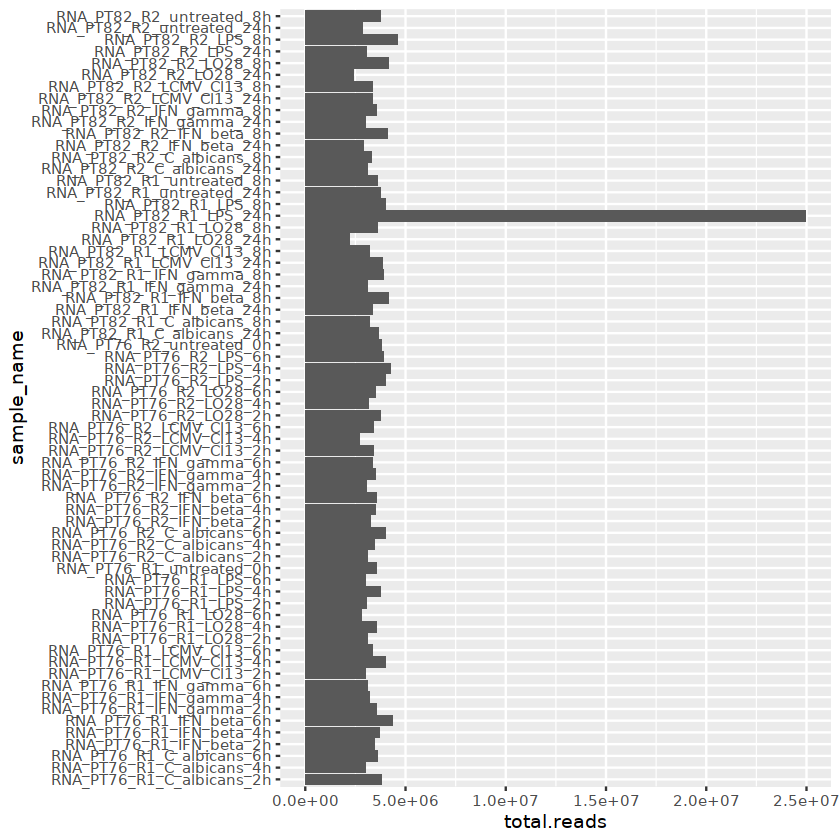

In [22]:
annot$total.reads <- colSums(countMT[,rownames(annot)])
annot <- annot[order(annot$total.reads),]
annot[annot$total.reads > 1e7,]
ggplot(annot, aes(x=sample_name, y=total.reads)) + geom_bar(stat="identity") + coord_flip()
ggsave(file.path(results_path, "QC_NumberOfReads.pdf"), w=8,h=15)

In [23]:
# remove outlier sample -> yes
annot <- annot[annot$total.reads < 1e7,]
countMT <- countMT[,annot$sample_name]
dim(countMT)

[1] 55487    65

In [24]:
# remove weirdly behaving sample according to PCA & correlation Heatmap & DEA -> yes
annot <- annot[annot$sample_name!='RNA_PT82_R1_untreated_8h',]
countMT <- countMT[,annot$sample_name]
dim(countMT)

[1] 55487    64

# Correlation Heatmap

In [25]:
corMT <- cor(countMT, method = "spearman")
diag(corMT) <- NA

In [26]:
pheatmap(corMT,
        file=file.path(results_path, "QC_CorrelationHM.pdf"),
         width=12,
         height=12
        )

# QC PCA

In [27]:
pr <- prcomp(t(voom(counts=countMT)$E), center=TRUE, scale.=TRUE, )
# biplot(pr)
pr.x <- data.table(pr$x, keep.rownames=T)
pr.x <- merge(pr.x, annot, by.x="rn", by.y="sample_name")
pr.x[,time2 := factor(time)]
grobs <- list()
for(i in 1:min(floor(length(grep("^PC\\d+$", colnames(pr.x)))/2),4)){
    var1 <- round(summary(pr)$importance['Proportion of Variance',paste0("PC", i*2-1)]*100)
    var2 <- round(summary(pr)$importance['Proportion of Variance',paste0("PC", i*2)]*100)
    
  grobs[[i]] <- ggplot(pr.x, aes_string(x=paste0("PC", i*2-1), y=paste0("PC", i*2), color="treatment", shape="time2")) + 
    geom_point() + 
    theme_bw(16) +
    scale_shape_manual(values=rep(c(1,16,2,18,3,4), 20)) + 
    xlab(paste0("PC", i*2-1,' (',var1,'%)')) + 
    ylab(paste0("PC", i*2,' (',var2,'%)'))
}
(p <- gridExtra::arrangeGrob(grobs=grobs,ncol=2))
ggsave(file.path(results_path, "QC_PCA.pdf"), w=12, h=10, plot=p)

grobs <- list()
for(i in 1:min(floor(length(grep("^PC\\d+$", colnames(pr.x)))/2),4)){
    var1 <- round(summary(pr)$importance['Proportion of Variance',paste0("PC", i*2-1)]*100)
    var2 <- round(summary(pr)$importance['Proportion of Variance',paste0("PC", i*2)]*100)
    
  grobs[[i]] <- ggplot(pr.x, aes_string(x=paste0("PC", i*2-1), y=paste0("PC", i*2), color="experiment", shape="experiment")) + 
    geom_point() + 
    theme_bw(16) +
    scale_shape_manual(values=rep(c(1,16,2,18,3,4), 20)) + 
    xlab(paste0("PC", i*2-1,' (',var1,'%)')) + 
    ylab(paste0("PC", i*2,' (',var2,'%)'))
}
(p <- gridExtra::arrangeGrob(grobs=grobs,ncol=2))
ggsave(file.path(results_path, "QC_PCA_Experiment.pdf"), w=12, h=10, plot=p)

TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]

TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]

In [28]:
# special IFN focused PCA consising only of untreated, IFN-beta, IFN-gamma
special_idx <- (annot$treatment=='untreated' & annot$time=='0h')|(annot$treatment=='IFN_beta')|(annot$treatment=='IFN_gamma')
special_samples <- rownames(annot)[special_idx]

pr <- prcomp(t(voom(counts=countMT[,special_samples])$E), center=TRUE, scale.=TRUE, )
# biplot(pr)
pr.x <- data.table(pr$x, keep.rownames=T)
pr.x <- merge(pr.x, annot, by.x="rn", by.y="sample_name")
pr.x[,time2 := factor(time)]
grobs <- list()
for(i in 1:min(floor(length(grep("^PC\\d+$", colnames(pr.x)))/2),4)){
    var1 <- round(summary(pr)$importance['Proportion of Variance',paste0("PC", i*2-1)]*100)
    var2 <- round(summary(pr)$importance['Proportion of Variance',paste0("PC", i*2)]*100)
    
  grobs[[i]] <- ggplot(pr.x, aes_string(x=paste0("PC", i*2-1), y=paste0("PC", i*2), color="treatment", shape="time2")) + 
    geom_point() + 
    theme_bw(16) +
    scale_shape_manual(values=rep(c(1,16,2,18,3,4), 20)) + 
    xlab(paste0("PC", i*2-1,' (',var1,'%)')) + 
    ylab(paste0("PC", i*2,' (',var2,'%)'))
}
(p <- gridExtra::arrangeGrob(grobs=grobs,ncol=2))
ggsave(file.path(results_path, "QC_PCA_IFN.pdf"), w=12, h=10, plot=p)

grobs <- list()
for(i in 1:min(floor(length(grep("^PC\\d+$", colnames(pr.x)))/2),4)){
    var1 <- round(summary(pr)$importance['Proportion of Variance',paste0("PC", i*2-1)]*100)
    var2 <- round(summary(pr)$importance['Proportion of Variance',paste0("PC", i*2)]*100)
    
  grobs[[i]] <- ggplot(pr.x, aes_string(x=paste0("PC", i*2-1), y=paste0("PC", i*2), color="experiment", shape="experiment")) + 
    geom_point() + 
    theme_bw(16) +
    scale_shape_manual(values=rep(c(1,16,2,18,3,4), 20)) + 
    xlab(paste0("PC", i*2-1,' (',var1,'%)')) + 
    ylab(paste0("PC", i*2,' (',var2,'%)'))
}
(p <- gridExtra::arrangeGrob(grobs=grobs,ncol=2))
ggsave(file.path(results_path, "QC_PCA_Experiment_IFN.pdf"), w=12, h=10, plot=p)

TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]

TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]

# filter genes

In [29]:
annot$group <- with(annot, paste(treatment, time, sep="_"))

In [30]:
# filter genes with edgeR
keep.exprs <- filterByExpr(countMT, group=annot$group)
filteredMT <- countMT[keep.exprs,]
dim(filteredMT)

[1] 12729    64

In [31]:
# save filtered count matrix
write.table(filteredMT, sep="\t", quote=F, row.names=T, file=file.path(data_path, paste0("all_filtered.tsv")))

# TMM normalization

In [32]:
dge <- DGEList(filteredMT, group=annot$group)
dge <- calcNormFactors(dge, method = "TMM")
normMT <- cpm(dge,  log=TRUE)
head(normMT)

RNA_PT82_R1_LO28_24h RNA_PT82_R2_LO28_24h
ENSMUSG00000098104 -0.8077601           0.1643132           
ENSMUSG00000033845  5.0625218           4.9697340           
ENSMUSG00000025903  5.1676743           5.0675152           
ENSMUSG00000033813  3.7903548           4.4947895           
ENSMUSG00000033793  7.9142737           7.6516922           
ENSMUSG00000025907  7.1047575           6.9108849           
                   RNA_PT76_R2_LCMV_Cl13_4h RNA_PT76_R1_LO28_6h
ENSMUSG00000098104 1.270408                 1.037207           
ENSMUSG00000033845 6.140173                 5.410492           
ENSMUSG00000025903 3.626889                 5.093400           
ENSMUSG00000033813 2.692106                 4.792992           
ENSMUSG00000033793 4.099340                 6.240462           
ENSMUSG00000025907 6.780420                 6.545034           
                   RNA_PT82_R2_untreated_24h RNA_PT82_R2_IFN_beta_24h
ENSMUSG00000098104 0.7564442                 0.9733263               
ENSMUSG00000033845 5.2594828                 5.2928509               
ENSMUSG00000025903 4.8895060                 4.8974943               
ENSMUSG00000033813 3.9434976                 4.4691518               
ENSMUSG00000033793 6.1212452                 6.2562633               
ENSMUSG00000025907 6.4091249                 6.7376657               
                   RNA_PT76_R1_LCMV_Cl13_2h RNA_PT76_R1_LPS_6h
ENSMUSG00000098104 1.957244                 0.09419716        
ENSMUSG00000033845 5.882193                 5.89771082        
ENSMUSG00000025903 4.658793                 4.57850483        
ENSMUSG00000033813 2.720925                 4.96974267        
ENSMUSG00000033793 4.790191                 5.12140012        
ENSMUSG00000025907 6.216007                 7.01774458        
                   RNA_PT76_R1_C_albicans_4h RNA_PT82_R2_IFN_gamma_24h ⋯
ENSMUSG00000098104 -0.8077601                0.2387836                 ⋯
ENSMUSG00000033845  5.8534899                5.5115070                 ⋯
ENSMUSG00000025903  4.9430773                4.8518579                 ⋯
ENSMUSG00000033813  3.5458669                4.2352021                 ⋯
ENSMUSG00000033793  6.4689107                5.7174741                 ⋯
ENSMUSG00000025907  6.0146982                6.2547085                 ⋯
                   RNA_PT76_R1_LCMV_Cl13_4h RNA_PT76_R2_C_albicans_6h
ENSMUSG00000098104 -0.03814591              0.007966385              
ENSMUSG00000033845  5.59947098              5.601636981              
ENSMUSG00000025903  5.23319521              4.599254130              
ENSMUSG00000033813  4.09418637              3.620179581              
ENSMUSG00000033793  6.08774019              6.009186262              
ENSMUSG00000025907  6.03998426              6.152588781              
                   RNA_PT82_R1_LPS_8h RNA_PT76_R2_LPS_2h
ENSMUSG00000098104 1.728579           1.045138          
ENSMUSG00000033845 5.784541           5.722510          
ENSMUSG00000025903 4.260100           4.926815          
ENSMUSG00000033813 4.010197           3.644968          
ENSMUSG00000033793 6.026317           5.769313          
ENSMUSG00000025907 7.155674           6.938884          
                   RNA_PT82_R2_IFN_beta_8h RNA_PT82_R2_LO28_8h
ENSMUSG00000098104 0.237038                -0.8077601         
ENSMUSG00000033845 5.429028                 5.1637929         
ENSMUSG00000025903 5.136991                 4.9688483         
ENSMUSG00000033813 5.555506                 5.1767592         
ENSMUSG00000033793 6.624256                 6.8431529         
ENSMUSG00000025907 6.779860                 6.6097149         
                   RNA_PT82_R1_IFN_beta_8h RNA_PT76_R2_LPS_4h
ENSMUSG00000098104 0.8437578               0.5730653         
ENSMUSG00000033845 5.1221710               5.6803090         
ENSMUSG00000025903 5.0033829               4.9310886         
ENSMUSG00000033813 5.0170750               4.4960264         
ENSMUSG00000033793 5.7493029               6.2713601         


In [33]:
# save filtered & normalized matrix
write.table(normMT, sep="\t", quote=F, row.names=T, file=file.path(data_path, paste0("all_TMMnorm.tsv")))

# CQN normalization

In [217]:
cqn_result <- cqn(filteredMT, 
               lengths = gene_annot[rownames(filteredMT), 'length'], 
               x = gene_annot[rownames(filteredMT), 'gc'],
               verbose = TRUE)

normCQN <- cqn_result$y + cqn_result$offset
dim(normCQN)
head(normCQN)

RQ fit ................................................................
SQN 

Warning message:
“The use of 'sig2' is deprecated; do specify 'sigma' (= sqrt(sig2)) instead”


.


NULL

$counts
                   RNA_PT82_R1_LO28_24h RNA_PT82_R2_LO28_24h
ENSMUSG00000098104                    0                    1
ENSMUSG00000033845                   52                   56
ENSMUSG00000025903                   56                   60
ENSMUSG00000033813                   21                   40
ENSMUSG00000033793                  381                  365
ENSMUSG00000025907                  217                  218
ENSMUSG00000090031                    3                    8
ENSMUSG00000103845                   31                   41
ENSMUSG00000033740                   43                   51
ENSMUSG00000104385                    1                    2
ENSMUSG00000051285                   49                   51
ENSMUSG00000076135                    0                    1
ENSMUSG00000061024                   20                   30
ENSMUSG00000025911                    0                    1
ENSMUSG00000079671                    0                    0
ENSMUSG00000025912                    4                    0
ENSMUSG00000045210                  254                  260
ENSMUSG00000025915                   89                   85
ENSMUSG00000046101                    1                    2
ENSMUSG00000098234                   30                   33
ENSMUSG00000093178                    6                    3
ENSMUSG00000025917                  163                  211
ENSMUSG00000056763                   88                   80
ENSMUSG00000067851                  141                  128
ENSMUSG00000102556                    9                    9
ENSMUSG00000005886                   37                   43
ENSMUSG00000103085                   14                    5
ENSMUSG00000102664                    5                    2
ENSMUSG00000025935                  260                  275
ENSMUSG00000025937                   30                   26
ENSMUSG00000102982                    1                    2
ENSMUSG00000025932                   55                   49
ENSMUSG00000102588                    3                    0
ENSMUSG00000025925                   19                    8
ENSMUSG00000043716                   18                   22
ENSMUSG00000025921                    8                    6
ENSMUSG00000025920                   21                   34
ENSMUSG00000025939                   25                   43
ENSMUSG00000079658                  167                  229
ENSMUSG00000025940                   42                   52
ENSMUSG00000025779                  117                  122
ENSMUSG00000100398                    0                    0
ENSMUSG00000041859                   22                   24
ENSMUSG00000025931                    0                    0
ENSMUSG00000041779                   24                   18
ENSMUSG00000025933                    0                    0
ENSMUSG00000025934                    6                   18
ENSMUSG00000026158                   61                   86
ENSMUSG00000026155                  263                  328
ENSMUSG00000026154                   11                   10
ENSMUSG00000026153                    1                    5
ENSMUSG00000101939                    6                    5
ENSMUSG00000101111                   28                   27
ENSMUSG00000102070                    8                   14
ENSMUSG00000073725                  143                  194
ENSMUSG00000048874                  215                  242
ENSMUSG00000104315                    8                    4
ENSMUSG00000026134                   10                    3
ENSMUSG00000004768                    1                    5
ENSMUSG00000042215                    2                    3
ENSMUSG00000042197                  113                   97
ENSMUSG00000042182                    2                    1
ENSMUSG00000026131                  763                  728
ENSMUSG00000103596                    9                   12
ENSMUSG00000103364         

In [221]:
# save filtered & normalized matrix
write.table(normCQN, sep="\t", quote=F, row.names=T, file=file.path(data_path, paste0("all_CQNnorm.tsv")))